<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/AnomaliaUDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento de reconhecimento de anomalias em ataque DoS do tipo UDP.

Fonte de dados:

Rede normal:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/benign/18-05-31.pcap

Rede com ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/AttackAndBenign/18-06-02.pcap

Descrição dos ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/attackinfo.xlsx

Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro `udp && (not snmp) && (not icmp) && (not ntp) && (not ssdp) && ip.src==192.168.0.0/16`. Posteriormente gerado dados no menu Statistics, I/O Graph, salvo como csv, nos intervalos de 1 minuto, 10 segundos, e 1 segundo.

Ataques UDP contabilizados com WireShark = [6](https://github.com/hflautert/AnomalyDetection/blob/main/Prints/WS_UDPn.PNG).

In [2]:
# Importando bibliotecas
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt
# Funcoes media movel
import httpimport
url = "https://gist.githubusercontent.com/hflautert/5bf858b4dc005877dcd340e67d9c4e85/raw/583b3967b639335ddd701dd73a9f97477dc38eec"
with httpimport.remote_repo(url):
  import funcoesmm as fmm

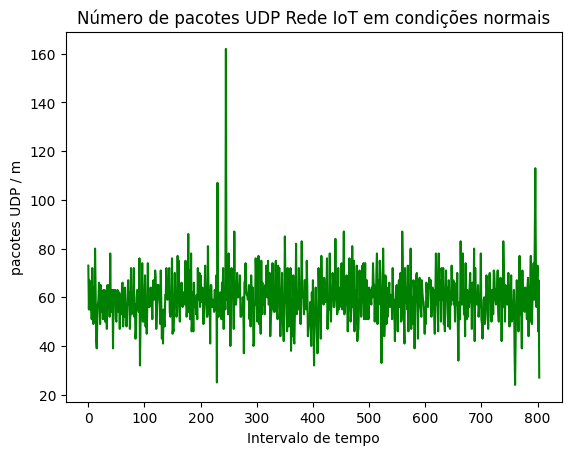

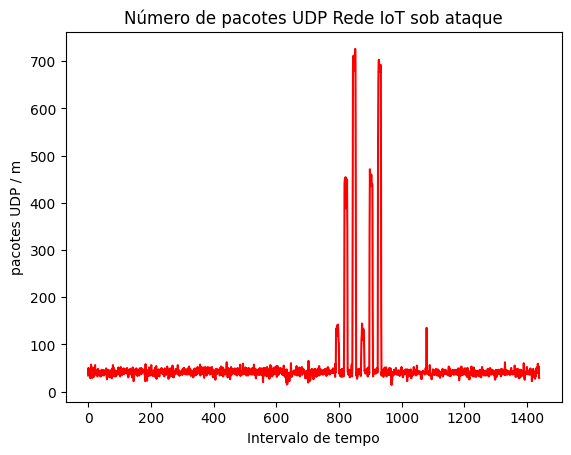

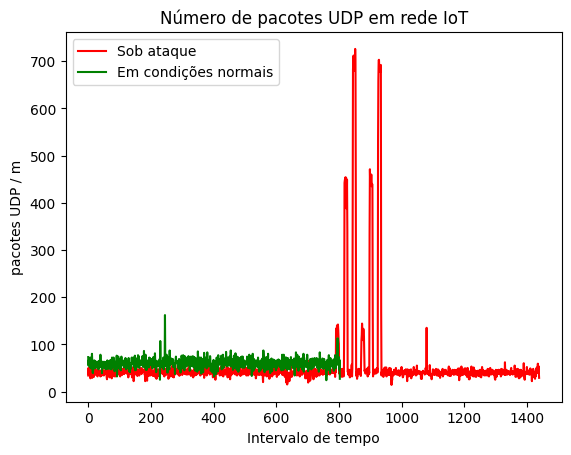

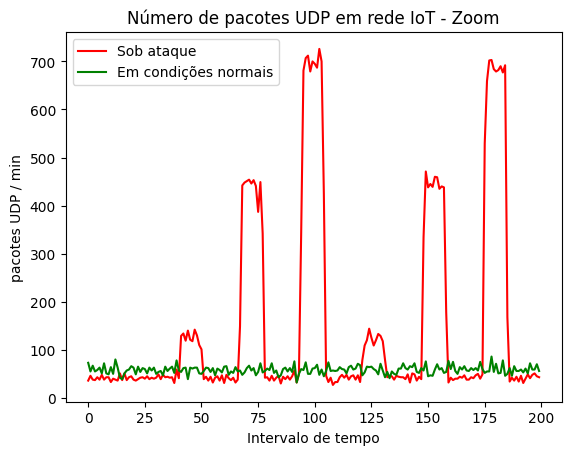

In [3]:
# Carregando dados
dados_normal_1m = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_udp_1m.csv")
dados_normal_10s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_udp_10s.csv")
dados_normal_1s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_udp_1s.csv")

dados_ataque_1m = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_udp_1m.csv")
dados_ataque_10s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_udp_10s.csv")
dados_ataque_1s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_udp_1s.csv")

tipo_dos_pacotes='UDP'

fmm.visualiza(dados_normal_1m,'m','g','Rede IoT em condições normais',tipo_dos_pacotes)
fmm.visualiza(dados_ataque_1m,'m','r','Rede IoT sob ataque',tipo_dos_pacotes)
fmm.visualizamix(dados_ataque_1m,'r',dados_normal_1m,'g','m',tipo_dos_pacotes)

# Vizualização otimizada com zoom na janela de ataque de 1, 10 e 100 pcts/s
v_dados_normal_1m = dados_normal_1m[:200]
v_dados_ataque_1m = dados_ataque_1m[750:950]

# Unindo linhas
plt.plot(v_dados_ataque_1m, color = 'r', label = "Sob ataque")
plt.plot(v_dados_normal_1m, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes '+tipo_dos_pacotes+' em rede IoT - Zoom')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes '+tipo_dos_pacotes+' / min')
plt.legend()
plt.show()

Total de ataques identificados: 6


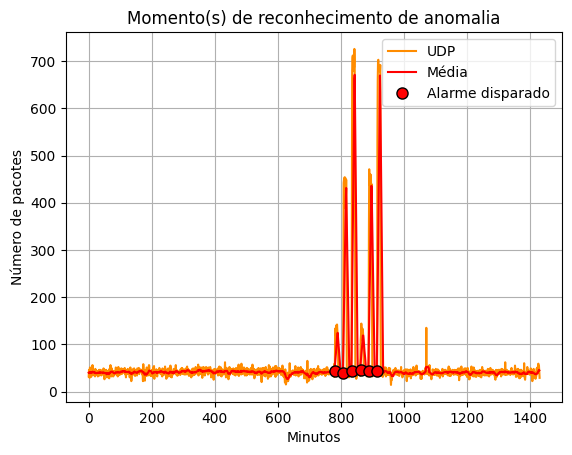

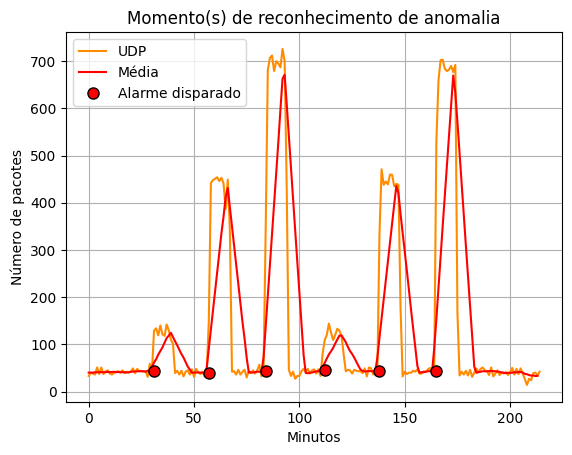

Falsos positivos: 0


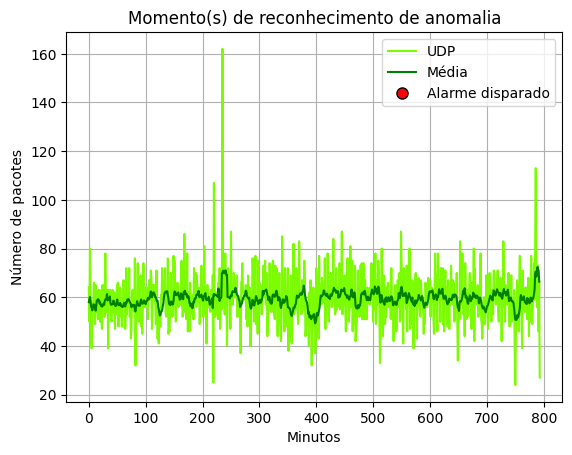

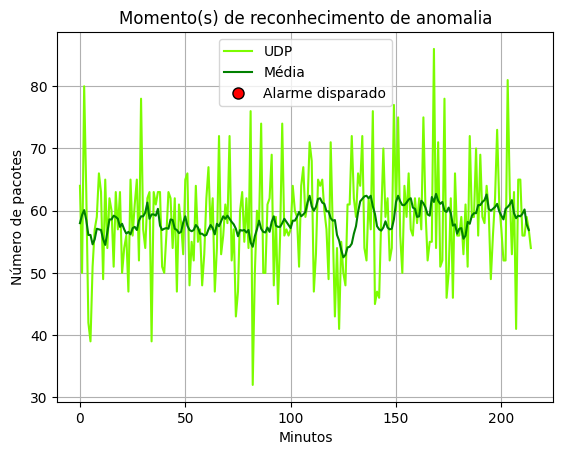

In [4]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1m
dados_ataque=dados_ataque_1m
unidade_de_tempo='Minutos'
delta=1.10
intervalo=10
taxa_minima=10

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[750:975]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[:225]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 6


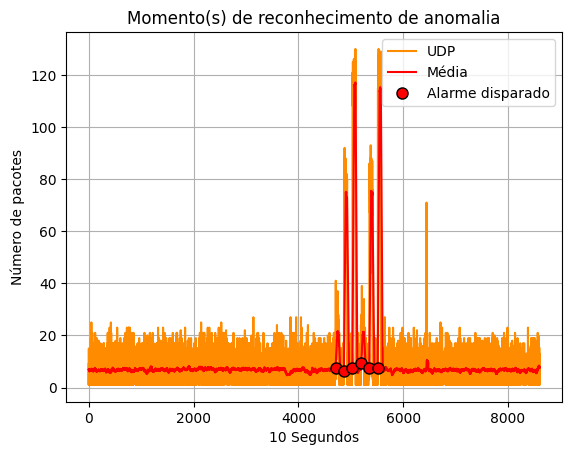

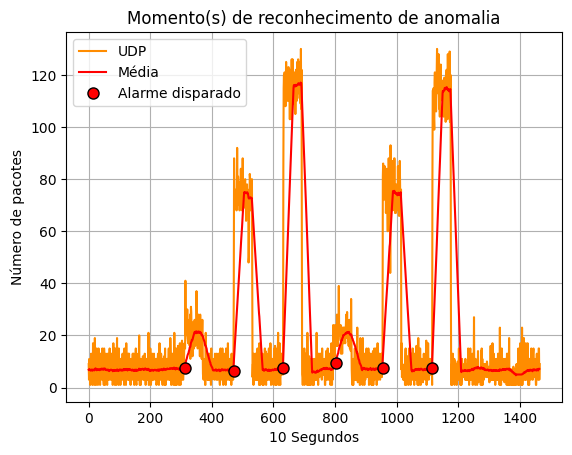

Falsos positivos: 1


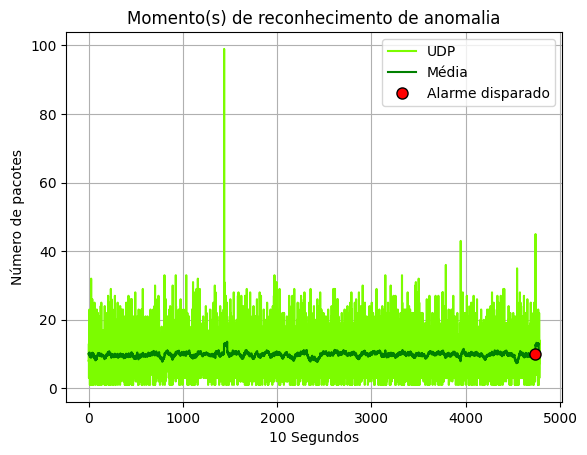

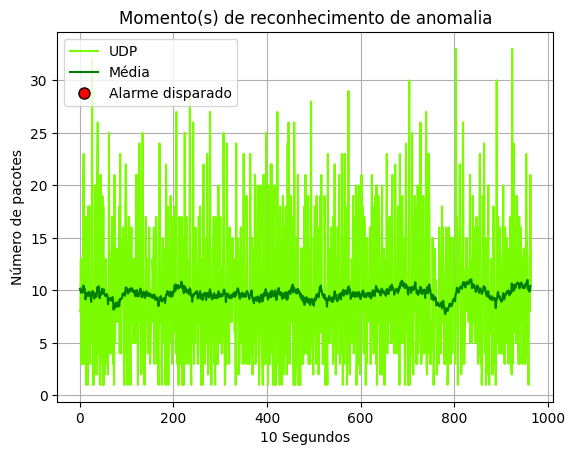

In [22]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_10s
dados_ataque=dados_ataque_10s
unidade_de_tempo='10 Segundos'
delta=1.06
intervalo=35
taxa_minima=5

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[4400:5900]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[:1000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 4


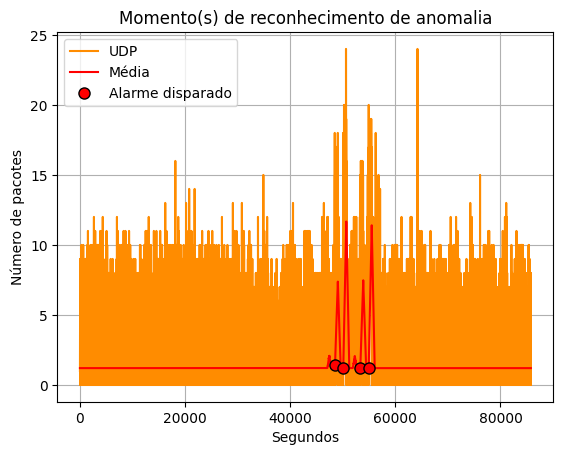

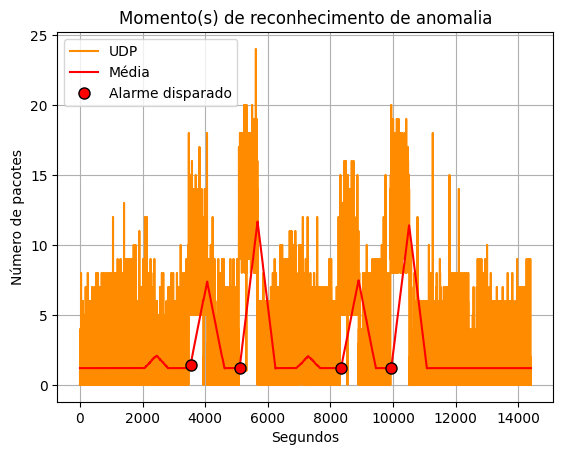

Falsos positivos: 0


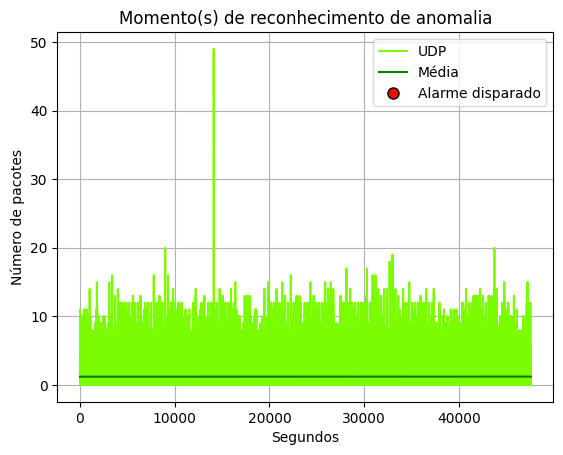

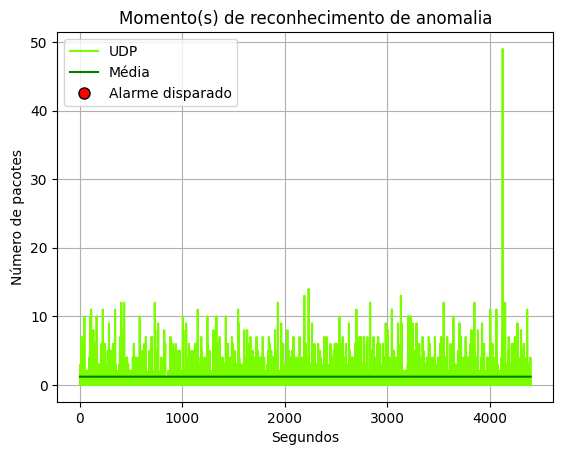

In [50]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1s
dados_ataque=dados_ataque_1s
unidade_de_tempo='Segundos'
delta=1.01
intervalo=600
taxa_minima=1.2

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[45000:60000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[10000:15000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)